In [1]:
# === Setup & Imports ===
import os, itertools, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Output directories
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

In [2]:
# === Utility helpers ===
def plot_confusion(cm, classes, title, save_path=None):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, title=title, ylabel='True', xlabel='Predicted')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def compute_metrics(y_true, y_pred, average='weighted'):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

In [33]:
# === Load Datasets ===
iris = datasets.load_iris()


datasets_map = {
    "Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),

}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['Iris']



[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9667 | Precision: 0.9697 | Recall: 0.9667 | F1: 0.9666
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



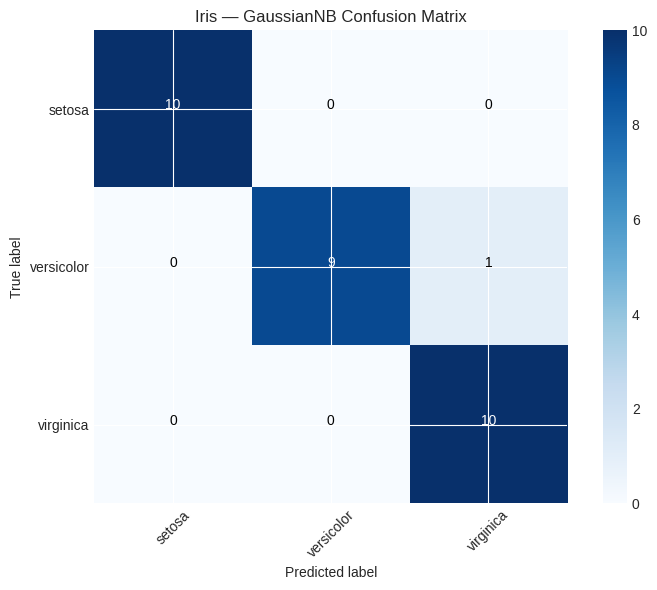


[Iris] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8333 | Precision: 0.8350 | Recall: 0.8333 | F1: 0.8329
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.78      0.70      0.74        10
   virginica       0.73      0.80      0.76        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



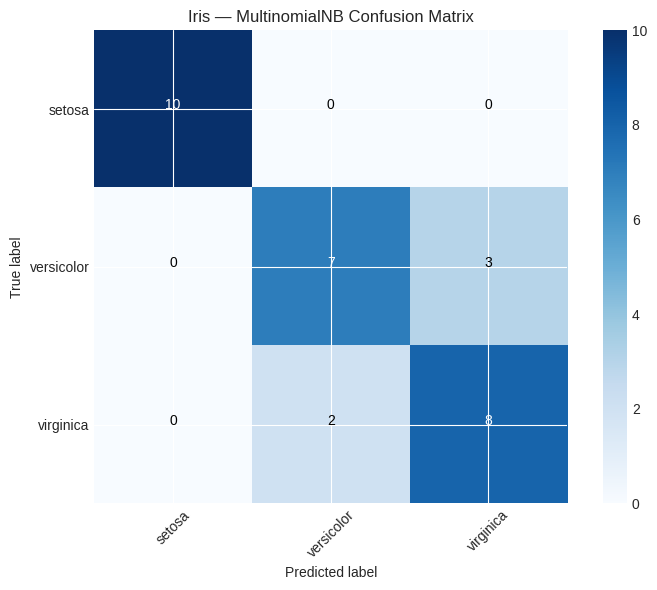


[Iris] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.4}
Test Accuracy: 0.7333 | Precision: 0.8194 | Recall: 0.7333 | F1: 0.6706
              precision    recall  f1-score   support

      setosa       0.83      1.00      0.91        10
  versicolor       1.00      0.20      0.33        10
   virginica       0.62      1.00      0.77        10

    accuracy                           0.73        30
   macro avg       0.82      0.73      0.67        30
weighted avg       0.82      0.73      0.67        30



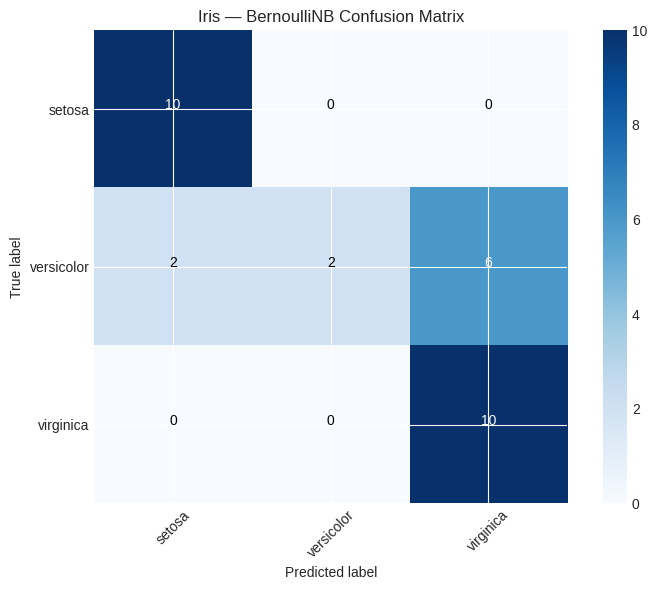


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.966667,0.969697,0.966667,0.966583
1,Iris,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.833333,0.835017,0.833333,0.832916
2,Iris,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.4}",0.733333,0.819444,0.733333,0.670552


In [34]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

[Iris] DecisionTree (gini) best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__splitter': 'best'}
Test Accuracy: 0.9667 | Precision: 0.9697 | Recall: 0.9667 | F1: 0.9666


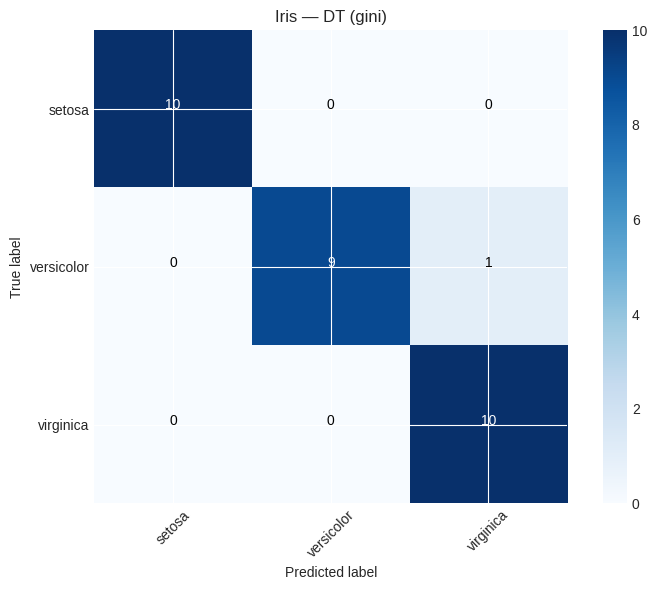

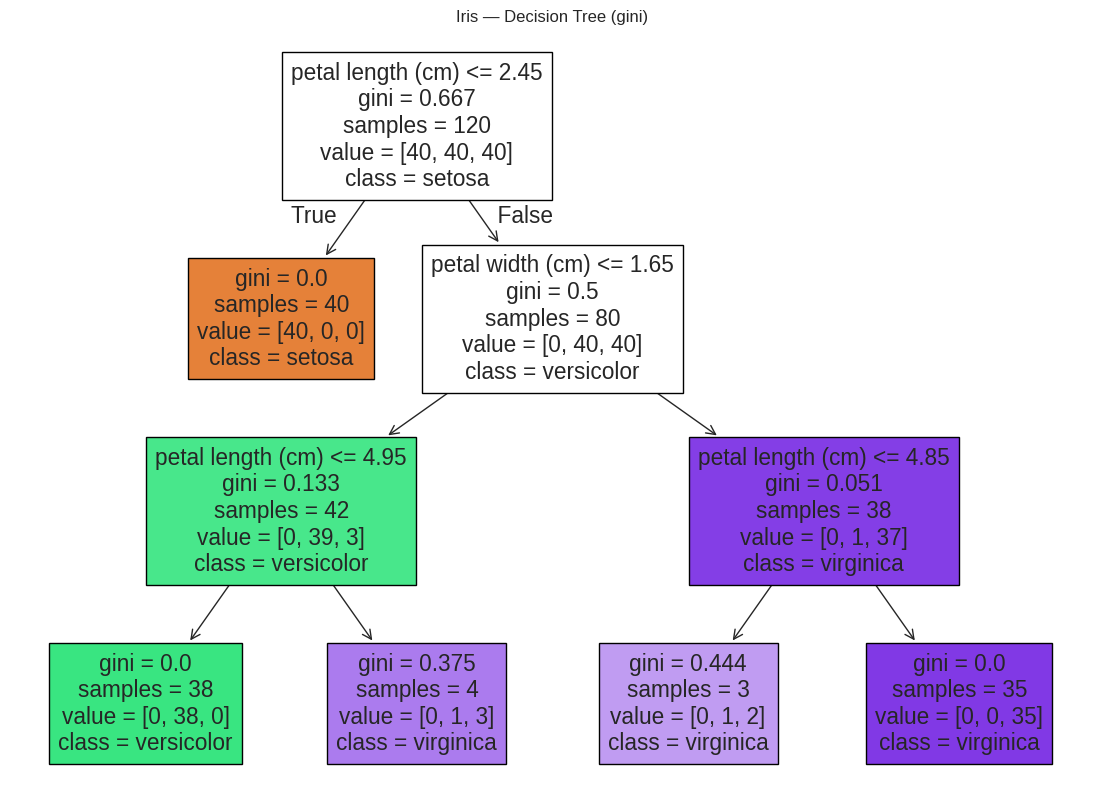

[Iris] DecisionTree (entropy) best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__splitter': 'random'}
Test Accuracy: 0.9333 | Precision: 0.9333 | Recall: 0.9333 | F1: 0.9333


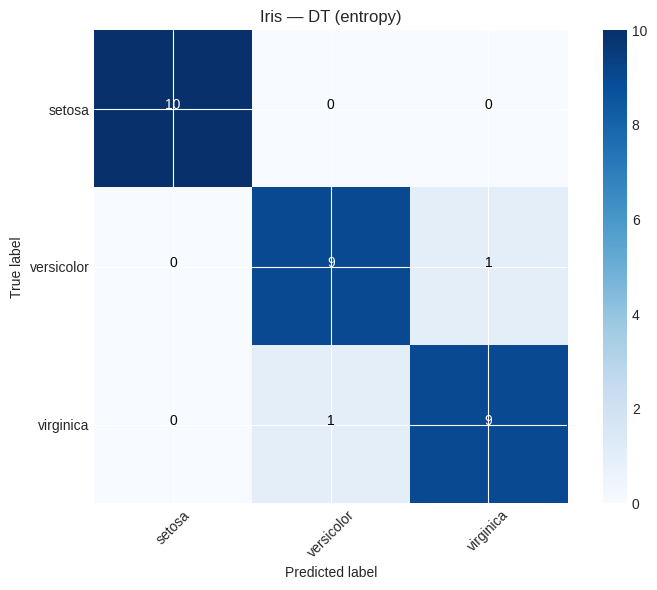

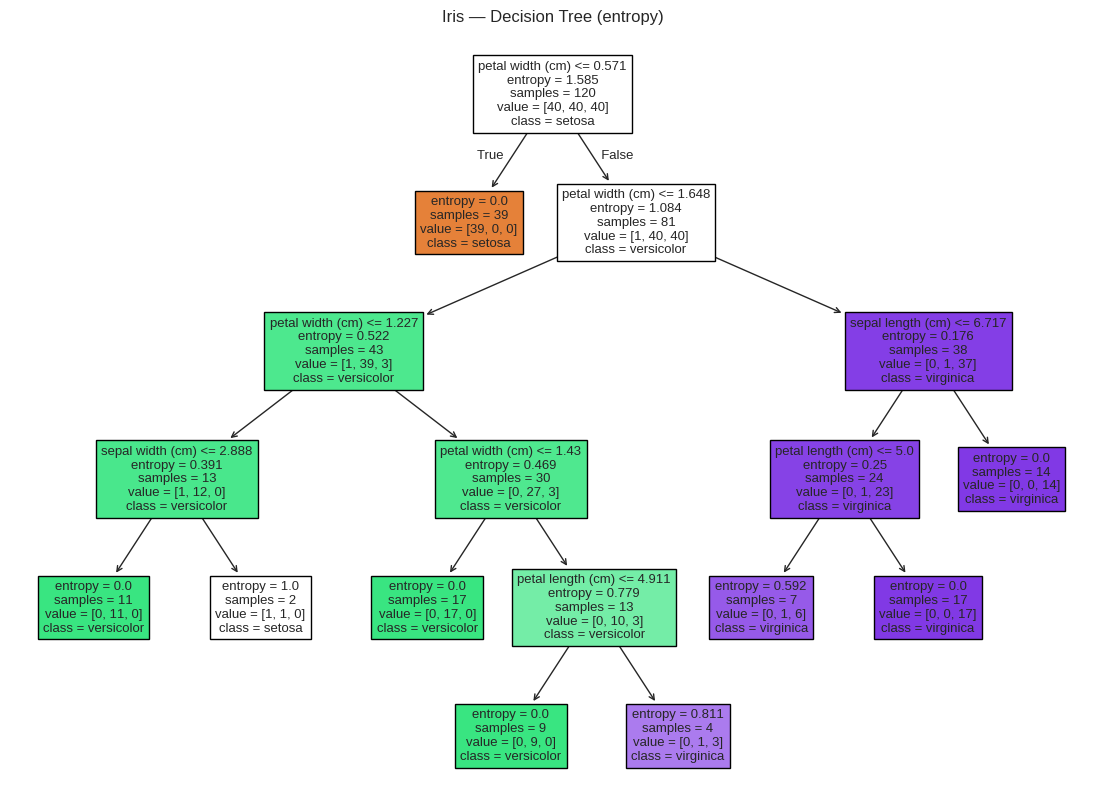


Saved Decision Tree summary to: outputs/decision_tree_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,tree_image
0,Iris,DecisionTree-gini,"{'clf__class_weight': None, 'clf__criterion': ...",0.966667,0.969697,0.966667,0.966583,outputs/Iris/DecisionTree/Gini/Iris_DT_gini_tr...
1,Iris,DecisionTree-entropy,"{'clf__class_weight': None, 'clf__criterion': ...",0.933333,0.933333,0.933333,0.933333,outputs/Iris/DecisionTree/Entropy/Iris_DT_entr...


In [35]:
# === Decision Trees (Gini & Entropy, images saved) ===

def fit_dt_for_criterion(dataset_name, split, criterion, base_outdir):
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    feat_names = split["feature_names"]
    class_names = split["class_names"]

    pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    grid = {
        'clf__criterion': [criterion],
        'clf__max_depth': [None, 3, 4, 5, 6, 8, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4],
        'clf__class_weight': [None, 'balanced'],
        'clf__splitter': ['best', 'random']
    }
    gs = GridSearchCV(pipe, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      n_jobs=-1, scoring='accuracy', refit=True)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_['clf']
    y_pred = gs.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    print(f"[{dataset_name}] DecisionTree ({criterion}) best params:", gs.best_params_)
    print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    outdir = os.path.join(base_outdir, criterion.capitalize())
    ensure_dir(outdir)
    cm_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_confusion.png")
    plot_confusion(cm, class_names, f"{dataset_name} — DT ({criterion})", save_path=cm_path)

    # Plot and save tree image
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(best_clf, feature_names=feat_names, class_names=class_names, filled=True, impurity=True)
    ax.set_title(f"{dataset_name} — Decision Tree ({criterion})")
    tree_img_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_tree.png")
    plt.savefig(tree_img_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return {
        "dataset": dataset_name, "model": f"DecisionTree-{criterion}",
        "best_params": gs.best_params_, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "tree_image": tree_img_path
    }

dt_rows = []
for dname, split in splits.items():
    base_out = os.path.join(OUT_DIR, dname, "DecisionTree")
    ensure_dir(base_out)
    for crit in ["gini", "entropy"]:
        row = fit_dt_for_criterion(dname, split, crit, base_out)
        dt_rows.append(row)

dt_results = pd.DataFrame(dt_rows)
dt_csv_path = os.path.join(OUT_DIR, "decision_tree_results.csv")
dt_results.to_csv(dt_csv_path, index=False)
print("\nSaved Decision Tree summary to:", dt_csv_path)
dt_results

In [36]:
# === Load Datasets ===
iris = datasets.load_iris()


datasets_map = {
    "Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),

}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['Iris']



[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9111 | Precision: 0.9155 | Recall: 0.9111 | F1: 0.9107
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



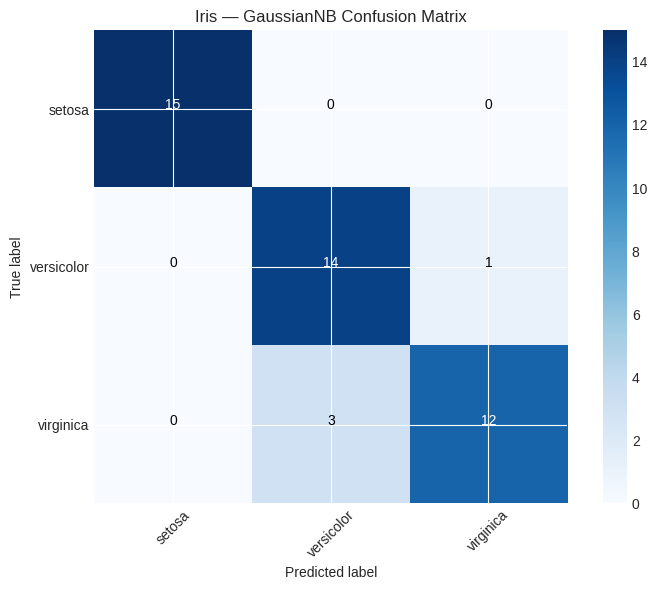


[Iris] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8222 | Precision: 0.8222 | Recall: 0.8222 | F1: 0.8222
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.73      0.73      0.73        15
   virginica       0.73      0.73      0.73        15

    accuracy                           0.82        45
   macro avg       0.82      0.82      0.82        45
weighted avg       0.82      0.82      0.82        45



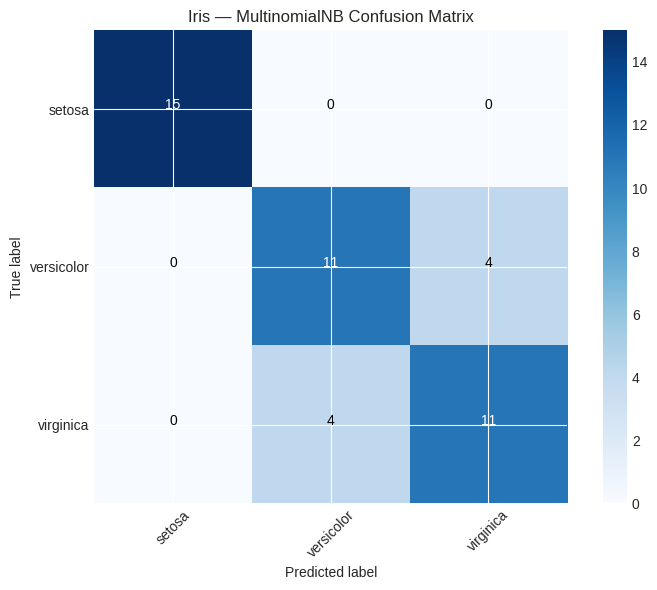


[Iris] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.4}
Test Accuracy: 0.7556 | Precision: 0.7840 | Recall: 0.7556 | F1: 0.7235
              precision    recall  f1-score   support

      setosa       0.88      1.00      0.94        15
  versicolor       0.83      0.33      0.48        15
   virginica       0.64      0.93      0.76        15

    accuracy                           0.76        45
   macro avg       0.78      0.76      0.72        45
weighted avg       0.78      0.76      0.72        45



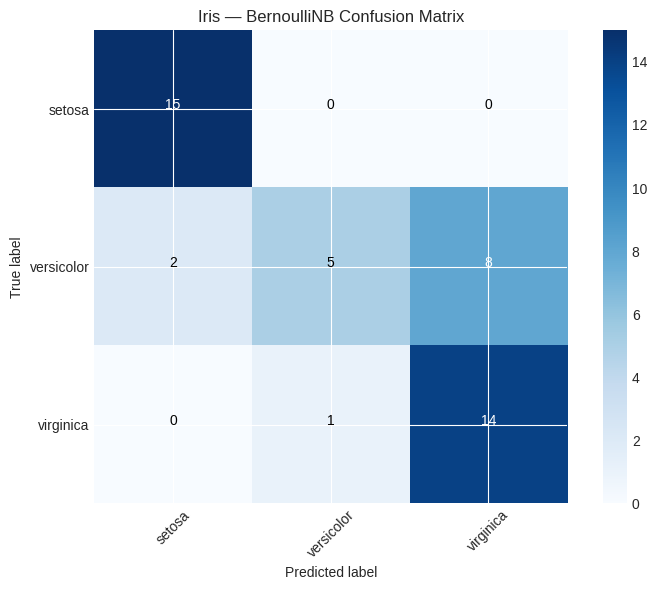


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.911111,0.915535,0.911111,0.910714
1,Iris,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.822222,0.822222,0.822222,0.822222
2,Iris,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.4}",0.755556,0.784017,0.755556,0.723482


In [37]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

In [38]:
# === Load Datasets ===
iris = datasets.load_iris()


datasets_map = {
    "Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),

}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['Iris']



[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9333 | Precision: 0.9360 | Recall: 0.9333 | F1: 0.9332
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        20
  versicolor       0.86      0.95      0.90        20
   virginica       0.94      0.85      0.89        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



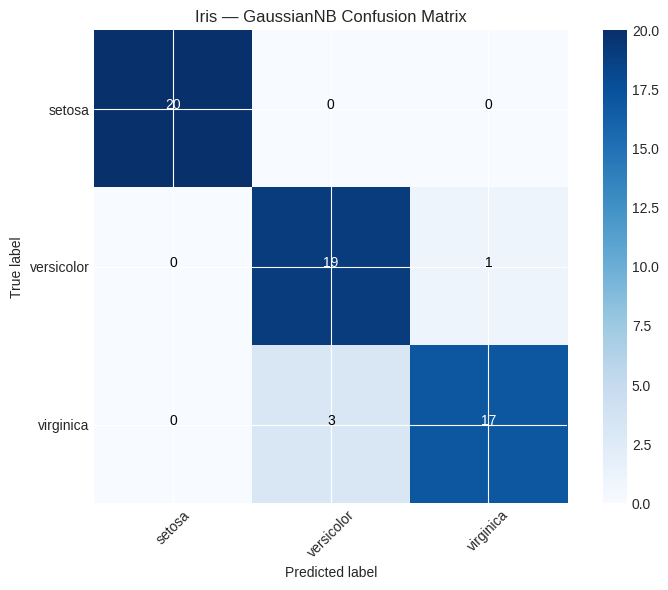


[Iris] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.7833 | Precision: 0.7860 | Recall: 0.7833 | F1: 0.7821
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        20
  versicolor       0.71      0.60      0.65        20
   virginica       0.65      0.75      0.70        20

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



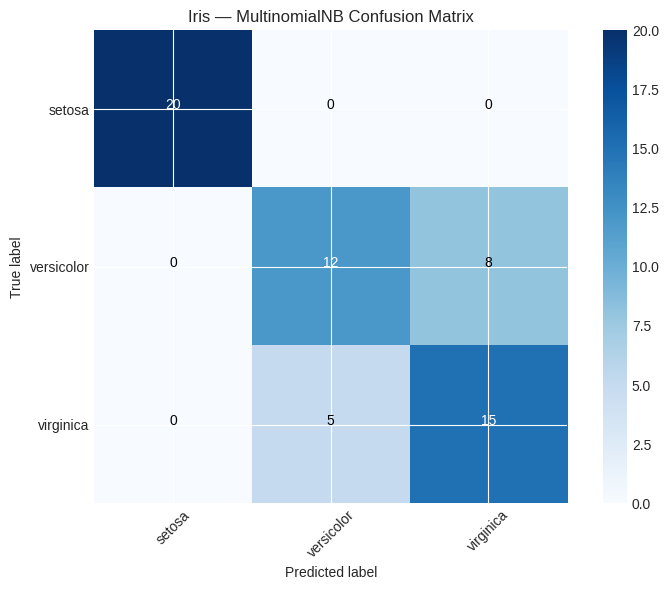


[Iris] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.3}
Test Accuracy: 0.7000 | Precision: 0.7063 | Recall: 0.7000 | F1: 0.6875
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        20
  versicolor       0.58      0.35      0.44        20
   virginica       0.54      0.75      0.62        20

    accuracy                           0.70        60
   macro avg       0.71      0.70      0.69        60
weighted avg       0.71      0.70      0.69        60



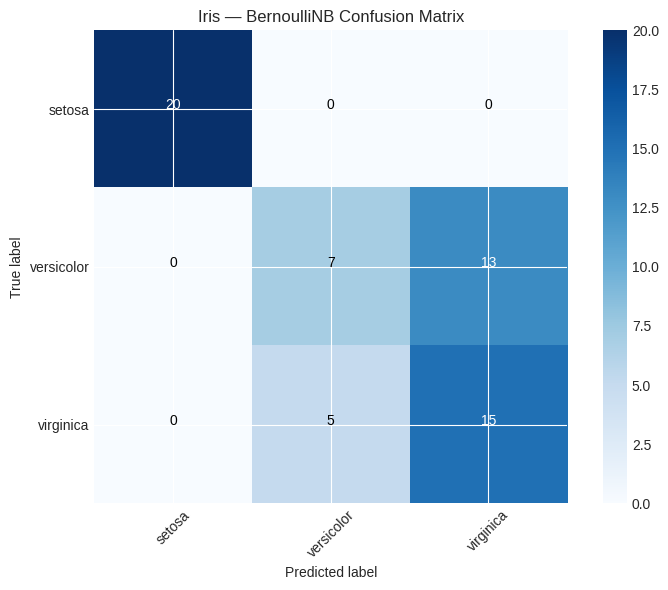


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.933333,0.936027,0.933333,0.933166
1,Iris,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.783333,0.786019,0.783333,0.782108
2,Iris,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.3}",0.700000,0.706349,0.700000,0.687500


In [39]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

In [40]:
# === Load Datasets ===
iris = datasets.load_iris()


datasets_map = {
    "Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),

}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['Iris']



[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9467 | Precision: 0.9485 | Recall: 0.9467 | F1: 0.9466
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.89      0.96      0.92        25
   virginica       0.96      0.88      0.92        25

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



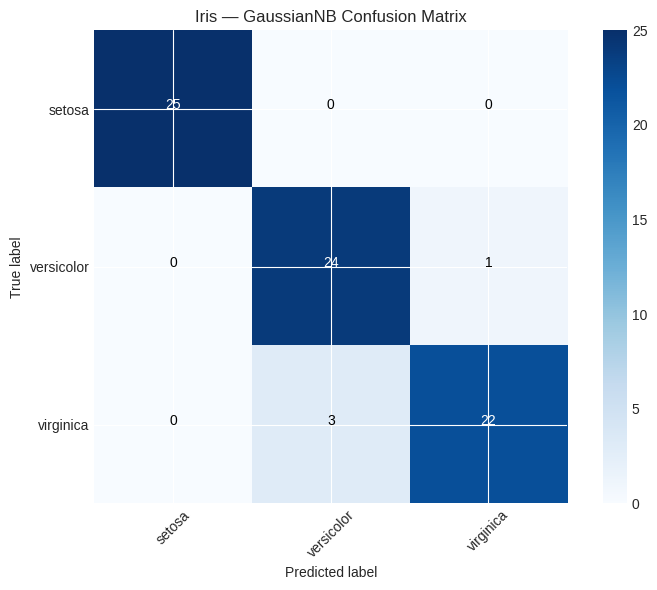


[Iris] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.5, 'clf__fit_prior': True}
Test Accuracy: 0.7867 | Precision: 0.7874 | Recall: 0.7867 | F1: 0.7863
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        25
  versicolor       0.70      0.64      0.67        25
   virginica       0.67      0.72      0.69        25

    accuracy                           0.79        75
   macro avg       0.79      0.79      0.79        75
weighted avg       0.79      0.79      0.79        75



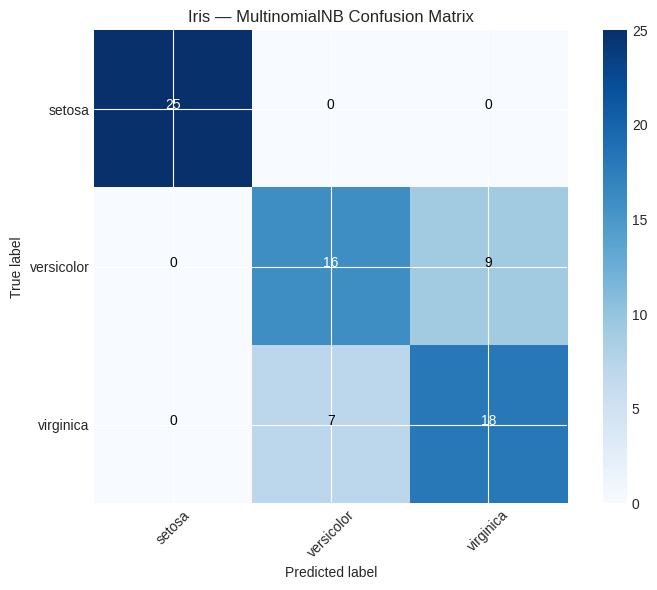


[Iris] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.4}
Test Accuracy: 0.6933 | Precision: 0.6851 | Recall: 0.6933 | F1: 0.6879
              precision    recall  f1-score   support

      setosa       0.93      1.00      0.96        25
  versicolor       0.54      0.56      0.55        25
   virginica       0.59      0.52      0.55        25

    accuracy                           0.69        75
   macro avg       0.69      0.69      0.69        75
weighted avg       0.69      0.69      0.69        75



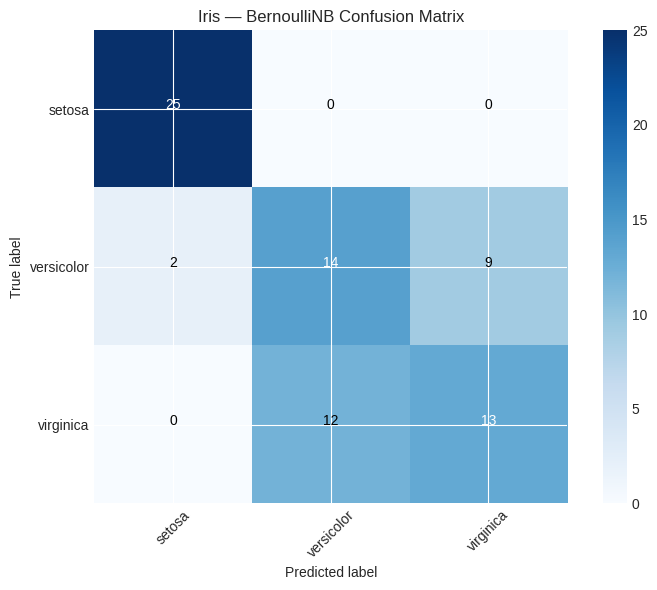


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.946667,0.948470,0.946667,0.946581
1,Iris,MultinomialNB,"{'clf__alpha': 0.5, 'clf__fit_prior': True}",0.786667,0.787440,0.786667,0.786325
2,Iris,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.4}",0.693333,0.685099,0.693333,0.687917


In [41]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

In [42]:
# === Load Datasets ===

bc = datasets.load_breast_cancer()

datasets_map = {

    "BreastCancer": (bc.data, bc.target, bc.feature_names, bc.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['BreastCancer']



[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9298 | Precision: 0.9298 | Recall: 0.9298 | F1: 0.9298
              precision    recall  f1-score   support

   malignant       0.90      0.90      0.90        42
      benign       0.94      0.94      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



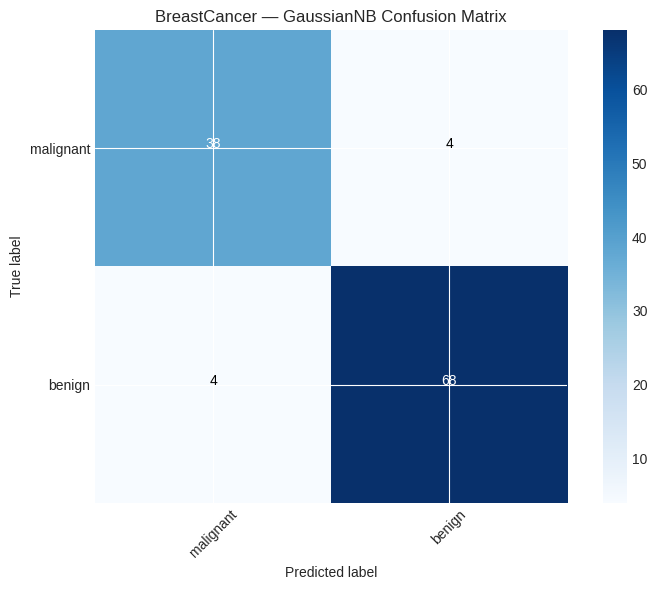


[BreastCancer] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8596 | Precision: 0.8852 | Recall: 0.8596 | F1: 0.8502
              precision    recall  f1-score   support

   malignant       1.00      0.62      0.76        42
      benign       0.82      1.00      0.90        72

    accuracy                           0.86       114
   macro avg       0.91      0.81      0.83       114
weighted avg       0.89      0.86      0.85       114



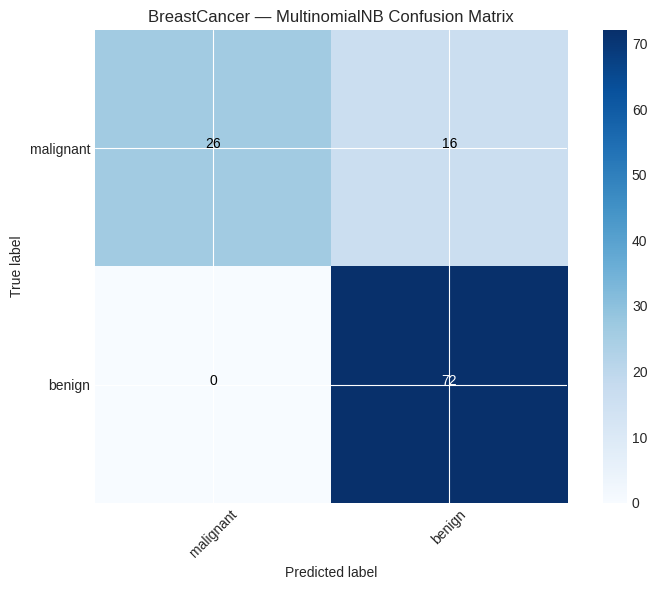


[BreastCancer] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.5, 'clf__binarize': 0.3}
Test Accuracy: 0.9211 | Precision: 0.9234 | Recall: 0.9211 | F1: 0.9216
              precision    recall  f1-score   support

   malignant       0.87      0.93      0.90        42
      benign       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



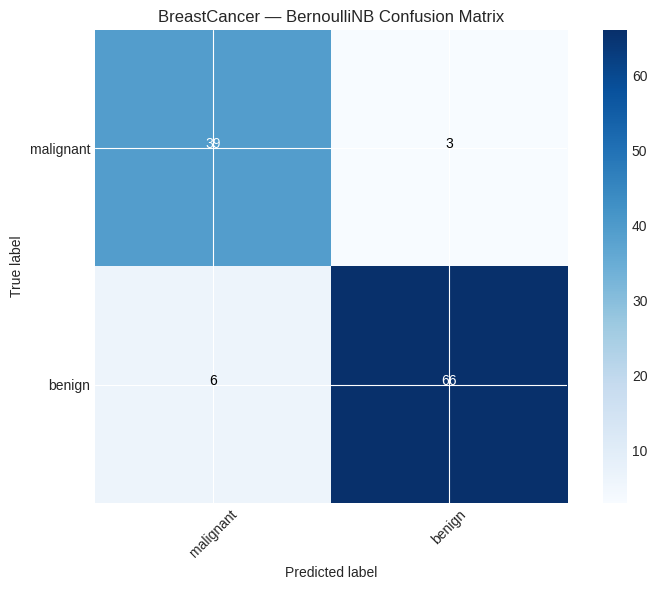


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.929825,0.929825,0.929825,0.929825
1,BreastCancer,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.859649,0.885167,0.859649,0.850155
2,BreastCancer,BernoulliNB,"{'clf__alpha': 0.5, 'clf__binarize': 0.3}",0.921053,0.923417,0.921053,0.921574


In [43]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

[BreastCancer] DecisionTree (gini) best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__splitter': 'random'}
Test Accuracy: 0.9439 | Precision: 0.9442 | Recall: 0.9439 | F1: 0.9440


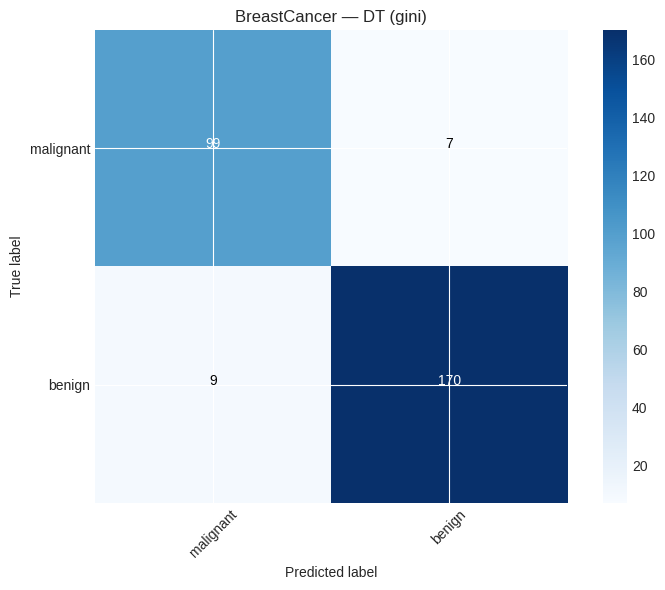

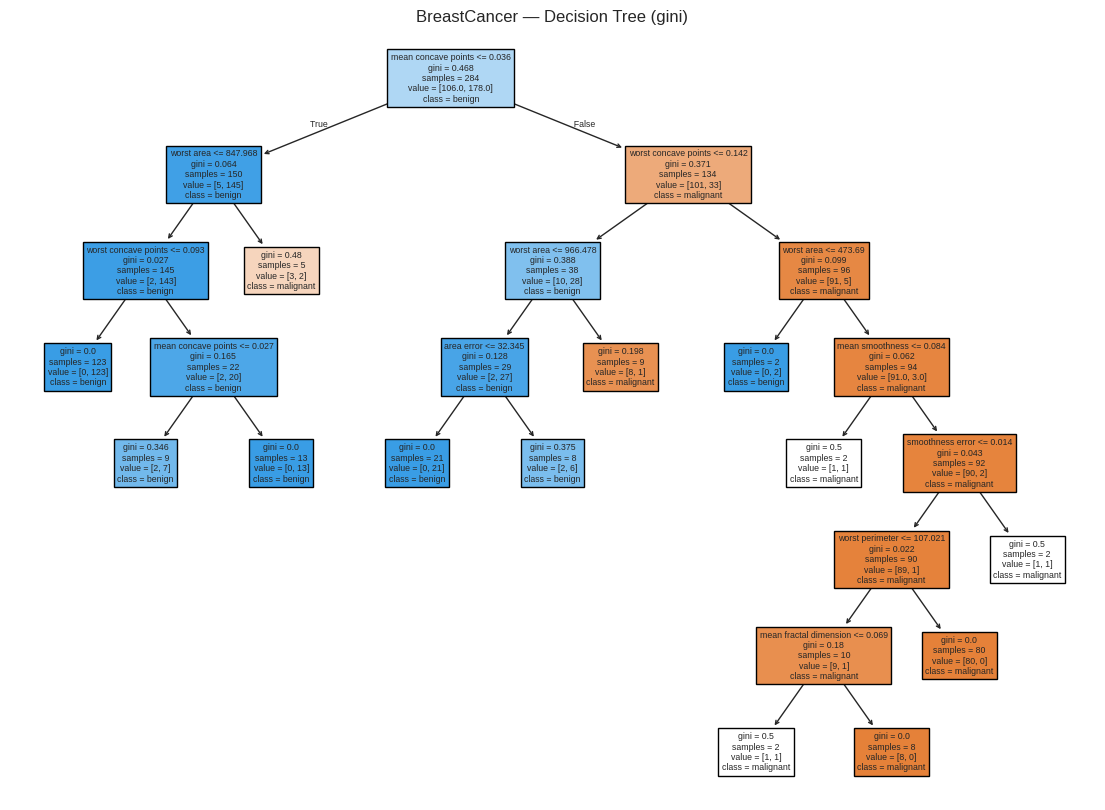

[BreastCancer] DecisionTree (entropy) best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
Test Accuracy: 0.9088 | Precision: 0.9106 | Recall: 0.9088 | F1: 0.9092


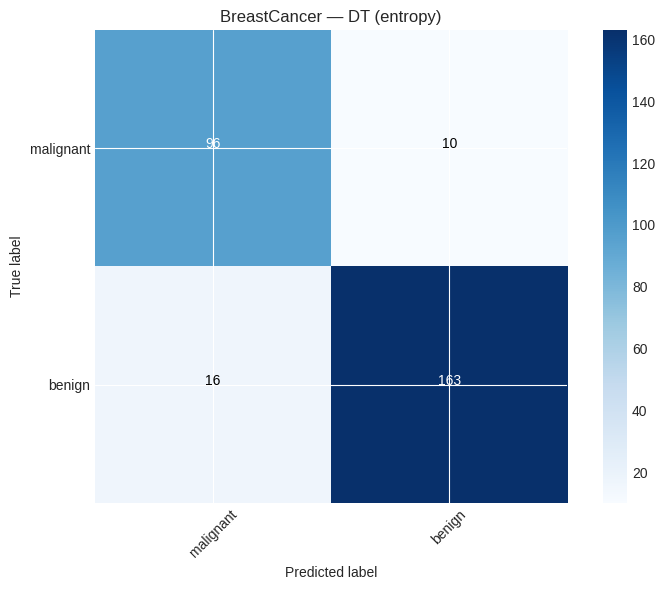

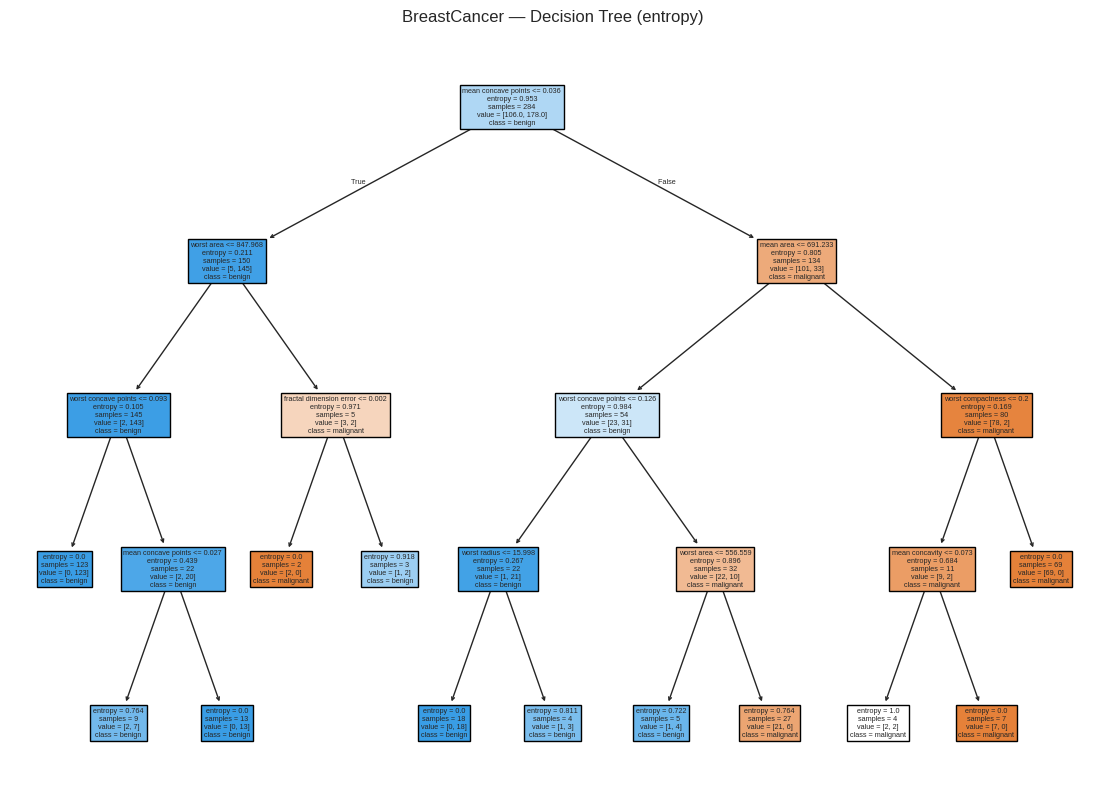


Saved Decision Tree summary to: outputs/decision_tree_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,tree_image
0,BreastCancer,DecisionTree-gini,"{'clf__class_weight': None, 'clf__criterion': ...",0.943860,0.944167,0.943860,0.943964,outputs/BreastCancer/DecisionTree/Gini/BreastC...
1,BreastCancer,DecisionTree-entropy,"{'clf__class_weight': None, 'clf__criterion': ...",0.908772,0.910563,0.908772,0.909250,outputs/BreastCancer/DecisionTree/Entropy/Brea...


In [32]:
# === Decision Trees (Gini & Entropy, images saved) ===

def fit_dt_for_criterion(dataset_name, split, criterion, base_outdir):
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    feat_names = split["feature_names"]
    class_names = split["class_names"]

    pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    grid = {
        'clf__criterion': [criterion],
        'clf__max_depth': [None, 3, 4, 5, 6, 8, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4],
        'clf__class_weight': [None, 'balanced'],
        'clf__splitter': ['best', 'random']
    }
    gs = GridSearchCV(pipe, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      n_jobs=-1, scoring='accuracy', refit=True)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_['clf']
    y_pred = gs.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    print(f"[{dataset_name}] DecisionTree ({criterion}) best params:", gs.best_params_)
    print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    outdir = os.path.join(base_outdir, criterion.capitalize())
    ensure_dir(outdir)
    cm_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_confusion.png")
    plot_confusion(cm, class_names, f"{dataset_name} — DT ({criterion})", save_path=cm_path)

    # Plot and save tree image
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(best_clf, feature_names=feat_names, class_names=class_names, filled=True, impurity=True)
    ax.set_title(f"{dataset_name} — Decision Tree ({criterion})")
    tree_img_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_tree.png")
    plt.savefig(tree_img_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return {
        "dataset": dataset_name, "model": f"DecisionTree-{criterion}",
        "best_params": gs.best_params_, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "tree_image": tree_img_path
    }

dt_rows = []
for dname, split in splits.items():
    base_out = os.path.join(OUT_DIR, dname, "DecisionTree")
    ensure_dir(base_out)
    for crit in ["gini", "entropy"]:
        row = fit_dt_for_criterion(dname, split, crit, base_out)
        dt_rows.append(row)

dt_results = pd.DataFrame(dt_rows)
dt_csv_path = os.path.join(OUT_DIR, "decision_tree_results.csv")
dt_results.to_csv(dt_csv_path, index=False)
print("\nSaved Decision Tree summary to:", dt_csv_path)
dt_results

In [26]:
# === Load Datasets ===

bc = datasets.load_breast_cancer()

datasets_map = {

    "BreastCancer": (bc.data, bc.target, bc.feature_names, bc.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['BreastCancer']



[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9357 | Precision: 0.9356 | Recall: 0.9357 | F1: 0.9353
              precision    recall  f1-score   support

   malignant       0.93      0.89      0.91        64
      benign       0.94      0.96      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



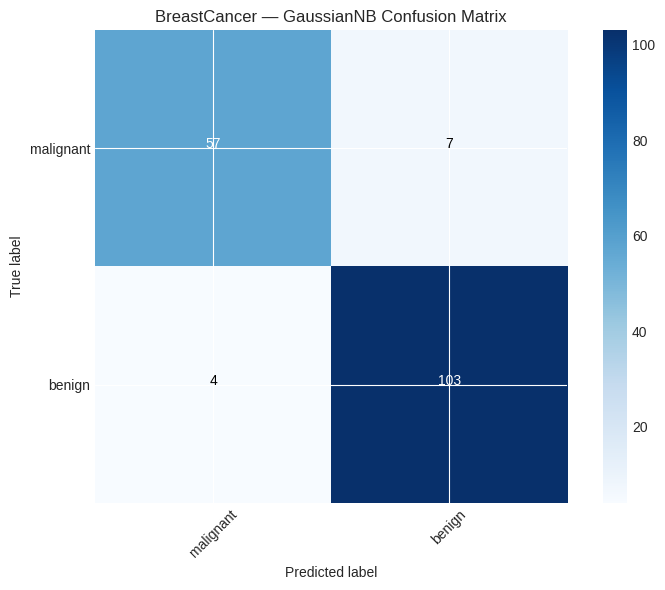


[BreastCancer] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8480 | Precision: 0.8777 | Recall: 0.8480 | F1: 0.8368
              precision    recall  f1-score   support

   malignant       1.00      0.59      0.75        64
      benign       0.80      1.00      0.89       107

    accuracy                           0.85       171
   macro avg       0.90      0.80      0.82       171
weighted avg       0.88      0.85      0.84       171



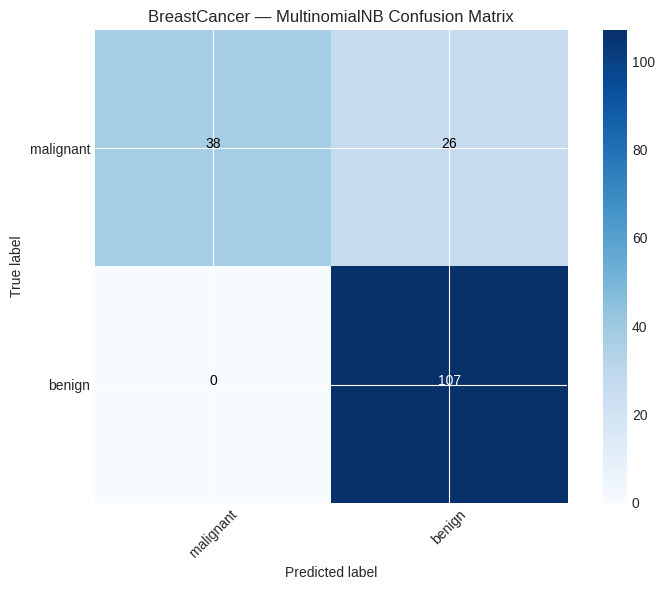


[BreastCancer] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.5, 'clf__binarize': 0.3}
Test Accuracy: 0.9415 | Precision: 0.9421 | Recall: 0.9415 | F1: 0.9417
              precision    recall  f1-score   support

   malignant       0.91      0.94      0.92        64
      benign       0.96      0.94      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



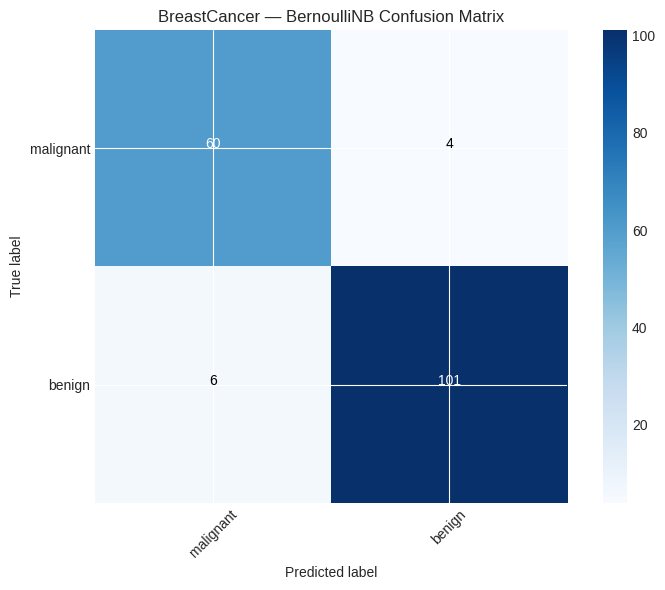


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.935673,0.935639,0.935673,0.935345
1,BreastCancer,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.847953,0.877677,0.847953,0.836811
2,BreastCancer,BernoulliNB,"{'clf__alpha': 0.5, 'clf__binarize': 0.3}",0.941520,0.942138,0.941520,0.941694


In [27]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

In [28]:
# === Load Datasets ===

bc = datasets.load_breast_cancer()

datasets_map = {

    "BreastCancer": (bc.data, bc.target, bc.feature_names, bc.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['BreastCancer']



[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9342 | Precision: 0.9343 | Recall: 0.9342 | F1: 0.9338
              precision    recall  f1-score   support

   malignant       0.94      0.88      0.91        85
      benign       0.93      0.97      0.95       143

    accuracy                           0.93       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.93      0.93      0.93       228



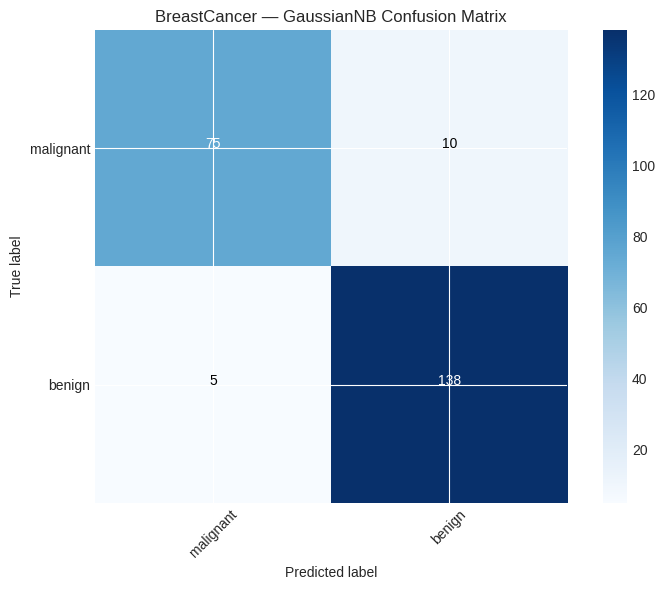


[BreastCancer] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8465 | Precision: 0.8717 | Recall: 0.8465 | F1: 0.8359
              precision    recall  f1-score   support

   malignant       0.98      0.60      0.74        85
      benign       0.81      0.99      0.89       143

    accuracy                           0.85       228
   macro avg       0.89      0.80      0.82       228
weighted avg       0.87      0.85      0.84       228



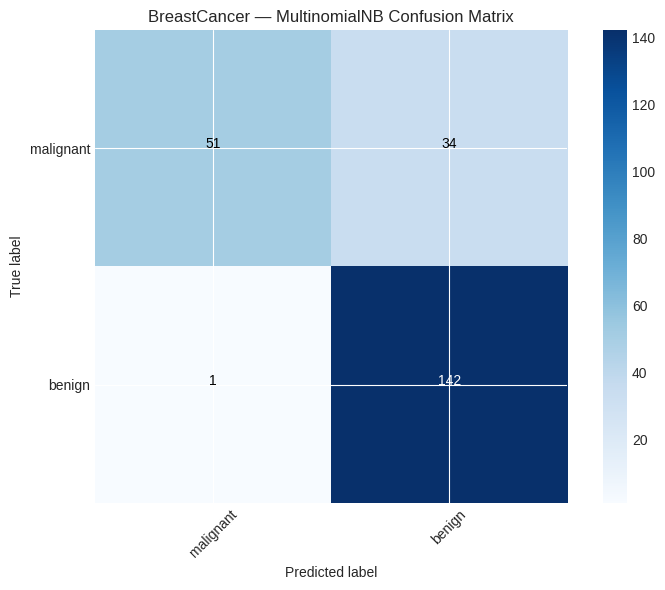


[BreastCancer] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.3}
Test Accuracy: 0.9342 | Precision: 0.9341 | Recall: 0.9342 | F1: 0.9341
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        85
      benign       0.94      0.95      0.95       143

    accuracy                           0.93       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.93      0.93      0.93       228



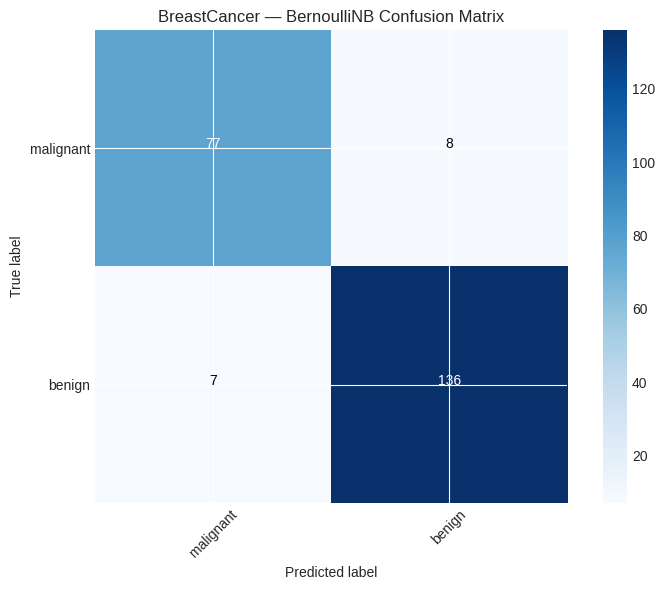


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.934211,0.934322,0.934211,0.933779
1,BreastCancer,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.846491,0.871668,0.846491,0.835943
2,BreastCancer,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.3}",0.934211,0.934089,0.934211,0.934130


In [29]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

In [30]:
# === Load Datasets ===

bc = datasets.load_breast_cancer()

datasets_map = {

    "BreastCancer": (bc.data, bc.target, bc.feature_names, bc.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['BreastCancer']



[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9368 | Precision: 0.9374 | Recall: 0.9368 | F1: 0.9363
              precision    recall  f1-score   support

   malignant       0.95      0.88      0.91       106
      benign       0.93      0.97      0.95       179

    accuracy                           0.94       285
   macro avg       0.94      0.92      0.93       285
weighted avg       0.94      0.94      0.94       285



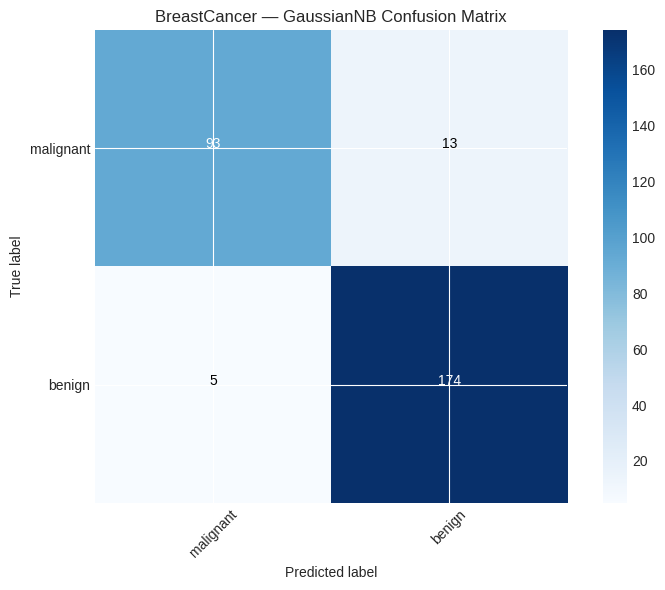


[BreastCancer] Tuning MultinomialNB ...
Best params: {'clf__alpha': 1.0, 'clf__fit_prior': True}
Test Accuracy: 0.8526 | Precision: 0.8733 | Recall: 0.8526 | F1: 0.8436
              precision    recall  f1-score   support

   malignant       0.97      0.62      0.76       106
      benign       0.82      0.99      0.89       179

    accuracy                           0.85       285
   macro avg       0.89      0.81      0.83       285
weighted avg       0.87      0.85      0.84       285



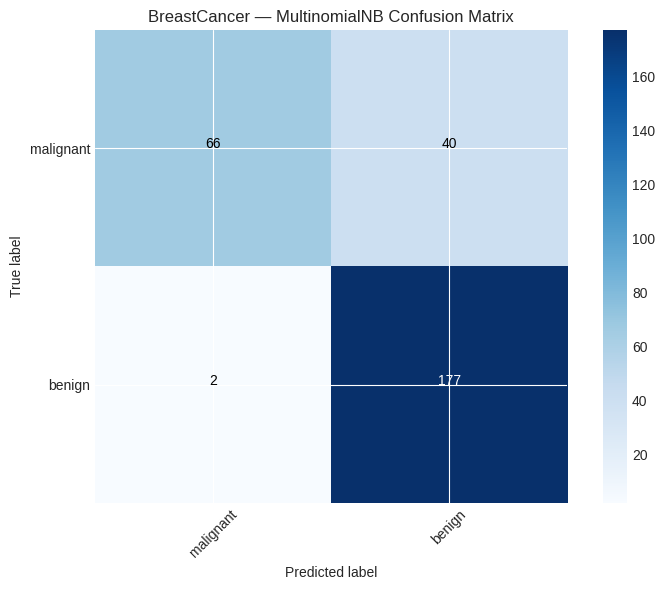


[BreastCancer] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.5, 'clf__binarize': 0.4}
Test Accuracy: 0.9404 | Precision: 0.9420 | Recall: 0.9404 | F1: 0.9396
              precision    recall  f1-score   support

   malignant       0.97      0.87      0.92       106
      benign       0.93      0.98      0.95       179

    accuracy                           0.94       285
   macro avg       0.95      0.93      0.93       285
weighted avg       0.94      0.94      0.94       285



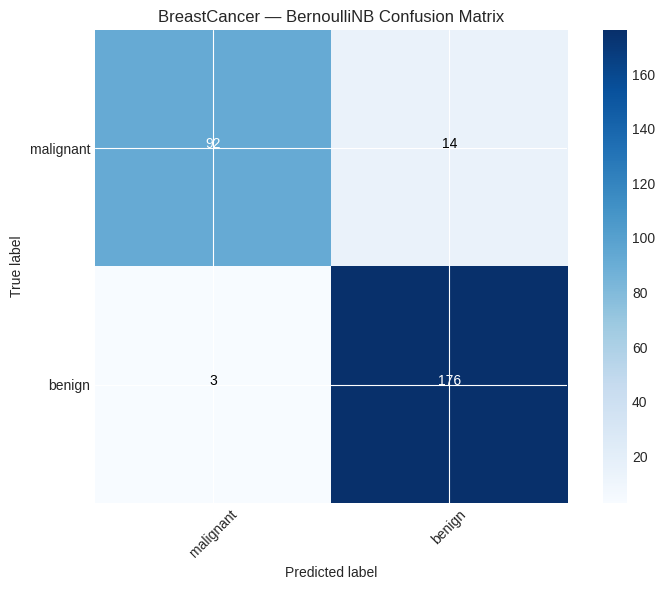


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.936842,0.937361,0.936842,0.936294
1,BreastCancer,MultinomialNB,"{'clf__alpha': 1.0, 'clf__fit_prior': True}",0.852632,0.873288,0.852632,0.843610
2,BreastCancer,BernoulliNB,"{'clf__alpha': 0.5, 'clf__binarize': 0.4}",0.940351,0.941976,0.940351,0.939608


In [31]:
# === Naive Bayes: Gaussian, Multinomial, Bernoulli ===

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results